# FEATURE SELECTION FIRST 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor , BaggingClassifier, RandomForestClassifier
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier


In [51]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [184]:
amz = pdr.get_data_yahoo("AMZN", start="2005-01-01", end="2020-06-21")

[*********************100%***********************]  1 of 1 completed


In [114]:
# add returns here later using different defintions then add them all to the amz df then test each one seperatly
# as a target variable and how correlations (linear) change with the change in the way returns are calculated

In [185]:
amz

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,45.130001,45.490002,44.160000,44.290001,44.290001,4790700
2005-01-03,44.950001,45.439999,44.209999,44.520000,44.520000,10446500
2005-01-04,42.669998,43.259998,41.500000,42.139999,42.139999,19418500
2005-01-05,41.570000,42.759998,41.560001,41.770000,41.770000,8354200
2005-01-06,41.810001,42.250000,40.900002,41.049999,41.049999,8700900
...,...,...,...,...,...,...
2020-06-15,2526.600098,2584.000000,2508.000000,2572.679932,2572.679932,3865100
2020-06-16,2620.000000,2620.000000,2576.000000,2615.270020,2615.270020,3585600
2020-06-17,2647.500000,2655.000000,2631.820068,2640.979980,2640.979980,2951100


In [97]:
def get_technical_indicators(dataset):
    '''
    params:
        dataset: OHLCV data for AMZ ticker from 1999-09-01 to 2019-09-20
    returns    
        features dataframe with the calculations of all technical Indicators such as 
        MACD, 20 period’s standard deviation, ROC, CCI, EMA
    '''
    # Sort values by dates. Old dates at top 
    dataset.sort_index(inplace=True)
    # Create the features  dataframe to store only the features
    features = pd.DataFrame(index=dataset.index)
    
    # Create 7 and 21 days Moving Average
    features['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    features['ma21'] = dataset['Adj Close'].rolling(window=21).mean()
    
    # Create MACD
    features['26ema'] = dataset['Adj Close'].ewm(span=26).mean()
    features['12ema'] = dataset['Adj Close'].ewm(span=12).mean()
    features['MACD'] = (features['12ema']-features['26ema'])
 
    # Create Bollinger Bands
    
    features['20sd'] = dataset['Adj Close'].rolling(20).std()
    features['upper_band'] = features['ma21'] + (features['20sd']*2)
    features['lower_band'] = features['ma21'] - (features['20sd']*2)
    
    # Create Exponential moving average
    features['ema'] = dataset['Adj Close'].ewm(span=20).mean()
    
    # ROC Rate of Change
    N = dataset['Adj Close'].diff(10)
    D = dataset['Adj Close'].shift(10)
    features['ROC'] = N/D
    
    # CCI  Commodity Channel Index
    TP = (dataset['High'] + dataset['Low'] + dataset['Adj Close']) / 3 
    features['CCI']  = (TP - TP.rolling(20).mean()) / (0.015 *  TP.rolling(20).std() )
    # Create Average True Range 
    features['TR'] = dataset['High'] - dataset['Low']
    features['ATR'] = features['TR'].ewm(span = 10).mean()
    features['volume'] = dataset['Volume']

    return features

In [98]:
features = get_technical_indicators(amz)

In [99]:
# Retrieve the features that will be used  in the vars_ dataframe
vars_ = features[['MACD','20sd','TR','ma21','ROC','CCI','volume']]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

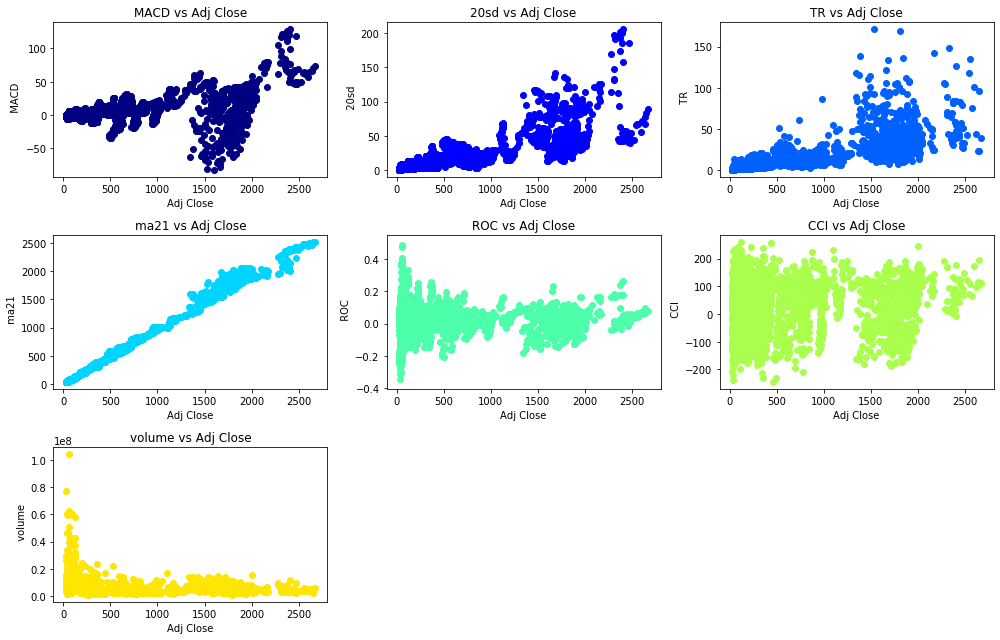

In [101]:
# The correlation() function would make scatterplots between each of the features and  the target variable 
# AdjClose
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
 
def correlation(df,features,variables, n_rows, n_cols):
    fig = plt.figure(figsize=(14,9))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = features.loc[:,var]
        ax.scatter(df["Adj Close"], asset, c = next(colors))
        ax.set_xlabel("Adj Close")
        ax.set_ylabel("  {}".format(var))
        ax.set_title(var +" vs Adj Close")
    fig.tight_layout() 
    plt.show()
        
columns = vars_.columns    
correlation(amz,vars_,columns,3,3)

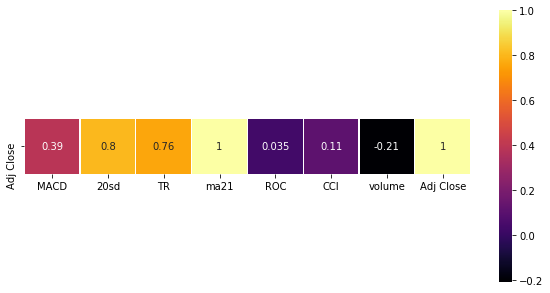

In [102]:
# Copy the vars_ dataframe into a new dataframe called df. 
# Add the target variable to the vars_ dataframe to make a correlation matrix among  features and target variable. Finally show a Heat Map with the values of the correlation matrix.
 
df = vars_.copy()
df['Adj Close'] = amz['Adj Close']
 
colormap = plt.cm.inferno
plt.figure(figsize=(10,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'Adj Close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);
plt.show()

In [103]:
# Fit Random Forest Regressor and extract feature importance
prices = pd.DataFrame(amz['Adj Close'])
vars_model = prices.join(vars_)
vars_model= vars_model.dropna()
 
X = vars_model[['MACD','20sd','TR','ROC','CCI','volume']].values
y = vars_model['Adj Close'].values
 
forest = RandomForestRegressor(n_estimators=100)
forest = forest.fit(X, y)
importances = forest.feature_importances_
 
values = list(zip(vars_model.columns[1:],importances))
headers = ['feature','score']
values_df = pd.DataFrame(values,columns = headers)

In [104]:
values_df

,feature,score
0,MACD,0.040269
1,20sd,0.612313
2,TR,0.267989
3,ma21,0.017175
4,ROC,0.008634
5,CCI,0.053620


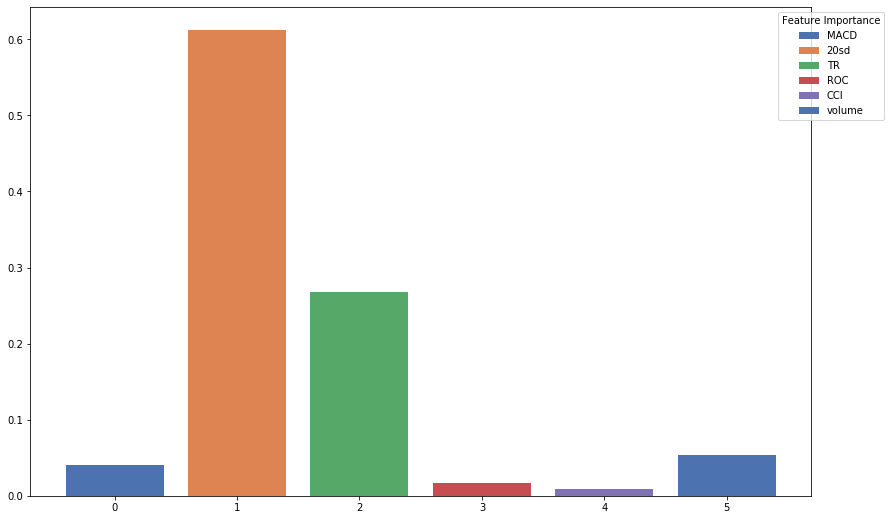

In [106]:
# Plot the feature importance
columns = ['MACD','20sd','TR','ROC','CCI','volume']
nd = np.arange(len(columns))
#width=0.5
fig = plt.figure(figsize=(14,9))
fig = plt.bar(nd, values_df['score'].values, color=sns.color_palette("deep", 5))
plt.legend(fig, columns, loc = 'upper right',bbox_to_anchor=(1.1, 1), title = "Feature Importance")
plt.show()

In [107]:
# Fit Sequentially Bootstrapped version of the Random Forest Regressor and extract feature importance



# Next is splitting your Dataset in to train - validate - test after choosing which features to include 

# 2ND RVERSE PCA

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from matplotlib.ticker import MaxNLocator
from scipy import stats

import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)



In [120]:
# GETTING DIVERSE SET OF DATA 
mix_asset_class = pdr.get_data_yahoo("AMZN GS ZC=F ES=F NG=F DVEM MORT PSJ SCATX RAAAX UMPSX EURJPY=X INR=X MXN=X ^MXX ^IXIC ^STOXX50E ^GDAXI ^VIX ^FTSE ^N225 ^HSI ^KS11",
                                     start="2005-01-01",
                                     end="2020-06-21")['Close']

[*********************100%***********************]  23 of 23 completed


In [123]:
mix_asset_class = mix_asset_class.dropna()

In [124]:
mix_asset_class

,AMZN,DVEM,ES=F,EURJPY=X,GS,INR=X,MORT,MXN=X,NG=F,PSJ,...,ZC=F,^FTSE,^GDAXI,^HSI,^IXIC,^KS11,^MXX,^N225,^STOXX50E,^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-07,591.429993,24.500000,2035.00,125.077003,150.410004,66.532997,19.40,17.880100,2.018,41.650002,...,361.50,6136.899902,9530.620117,20266.050781,4848.370117,1973.890015,45052.160156,15749.839844,2871.570068,16.160000
2016-04-08,594.599976,24.961000,2040.75,123.287003,150.279999,66.778999,19.50,17.767900,1.990,41.740002,...,362.25,6204.399902,9622.259766,20370.400391,4850.689941,1972.050049,44859.488281,15821.519531,2911.979980,15.360000
2016-04-11,595.929993,25.240000,2034.50,123.521004,152.199997,66.543999,19.75,17.650600,1.912,41.340000,...,356.75,6200.100098,9682.990234,20440.810547,4833.399902,1970.369995,44760.531250,15751.129883,2924.229980,16.260000
2016-04-12,603.169983,25.320000,2055.75,123.171997,154.309998,66.290001,19.77,17.475100,2.004,41.220001,...,362.75,6242.399902,9761.469727,20504.439453,4872.089844,1981.319946,45090.671875,15928.790039,2942.090088,14.850000
2016-04-14,620.750000,25.980000,2076.50,123.410004,160.910004,66.525002,19.84,17.431700,1.970,42.090000,...,374.00,6365.100098,10093.650391,21337.810547,4945.890137,2015.930054,45403.539062,16911.050781,3060.860107,13.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,1949.719971,23.440001,2569.75,119.150002,154.589996,75.400002,10.00,23.833000,1.640,85.739998,...,340.75,5672.000000,9935.839844,23603.480469,7700.100098,1754.640015,34554.531250,18917.009766,2786.899902,53.540001
2020-04-01,1907.699951,22.468700,2448.00,118.543999,145.289993,75.324997,8.45,23.750999,1.587,81.849998,...,334.75,5454.600098,9544.750000,23085.789062,7360.580078,1685.459961,33691.878906,18065.410156,2680.300049,57.060001
2020-04-02,1918.829956,23.190001,2516.50,117.489998,149.929993,77.570000,8.25,24.215500,1.552,83.349998,...,333.50,5480.200195,9570.820312,23280.060547,7487.310059,1724.859985,33590.621094,17818.720703,2688.489990,50.910000


In [125]:
def logrets(dataframe):
    dataframe = dataframe.dropna()
    rets = np.log(dataframe.astype('float') / dataframe.astype('float').shift(1))
    return rets

In [126]:
mix_asset_class_rets = logrets(mix_asset_class).dropna()

In [127]:
mix_asset_class_rets

,AMZN,DVEM,ES=F,EURJPY=X,GS,INR=X,MORT,MXN=X,NG=F,PSJ,...,ZC=F,^FTSE,^GDAXI,^HSI,^IXIC,^KS11,^MXX,^N225,^STOXX50E,^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-08,0.005346,0.018642,0.002822,-0.014415,-0.000865,0.003691,0.005141,-0.006295,-0.013972,0.002159,...,0.002073,0.010939,0.009569,0.005136,0.000478,-0.000933,-0.004286,0.004541,0.013974,-0.050772
2016-04-11,0.002234,0.011115,-0.003067,0.001896,0.012695,-0.003525,0.012739,-0.006624,-0.039985,-0.009629,...,-0.015299,-0.000693,0.006292,0.003451,-0.003571,-0.000852,-0.002208,-0.004459,0.004198,0.056941
2016-04-12,0.012076,0.003165,0.010391,-0.002829,0.013768,-0.003824,0.001012,-0.009993,0.046995,-0.002907,...,0.016679,0.006799,0.008072,0.003108,0.007973,0.005542,0.007349,0.011216,0.006089,-0.090708
2016-04-14,0.028729,0.025732,0.010043,0.001930,0.041882,0.003539,0.003534,-0.002487,-0.017112,0.020887,...,0.030542,0.019465,0.033464,0.039839,0.015034,0.017317,0.006915,0.059839,0.039576,-0.079145
2016-04-15,0.008246,0.000000,-0.000723,-0.002028,-0.014964,0.001682,0.002517,0.006513,-0.035128,0.006866,...,0.011960,-0.003352,-0.004178,-0.001001,-0.001552,-0.000605,0.002925,-0.003734,-0.002132,-0.007315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,-0.007272,-0.000776,-0.016020,-0.004029,-0.032020,-0.000862,-0.067659,0.010053,-0.030032,-0.010211,...,-0.001466,0.019278,0.012138,0.018315,-0.009571,0.021615,0.010314,-0.008840,0.007665,-0.064025
2020-04-01,-0.021787,-0.042321,-0.048537,-0.005099,-0.062045,-0.000995,-0.168419,-0.003447,-0.032851,-0.046431,...,-0.017765,-0.039082,-0.040157,-0.022177,-0.045095,-0.040225,-0.025282,-0.046062,-0.039001,0.063674
2020-04-02,0.005817,0.031598,0.027598,-0.008931,0.031437,0.029369,-0.023953,0.019368,-0.022301,0.018160,...,-0.003741,0.004682,0.002728,0.008380,0.017071,0.023107,-0.003010,-0.013749,0.003051,-0.114044


/home/ash/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



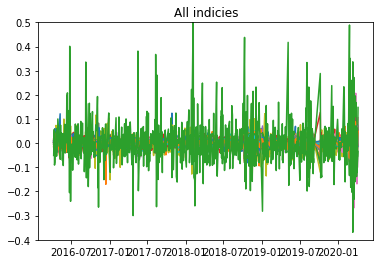

In [128]:
plt.plot(mix_asset_class_rets)
plt.title("All indicies")
plt.ylim([-0.4,0.5])
plt.show()

# Check if we have a stationary time series

In [136]:
# If the ADF test statistic is < -4 then we can reject the null hypothesis - i.e. we have a stationary time series

result = adfuller(mix_asset_class_rets.iloc[:,11].dropna())
"Result of ADF test: %s" % result[0]

'Result of ADF test: -11.769620255448629'

In [137]:
mix_asset_class_rets.iloc[:,11]

Date
2016-04-08   -0.005767
2016-04-11   -0.011634
2016-04-12    0.013735
2016-04-14    0.026406
2016-04-15    0.001021
                ...   
2020-03-31   -0.011076
2020-04-01   -0.047340
2020-04-02   -0.019293
2020-04-03   -0.013803
2020-04-06    0.066503
Name: SCATX, Length: 805, dtype: float64

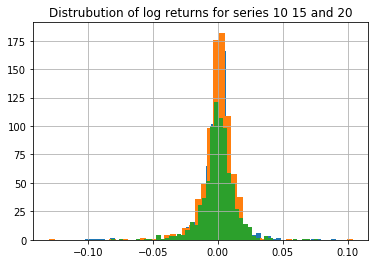

In [139]:


#plot a particular series - if it is approximately normal then there is a good chance we have a stationary series
plt.hist(mix_asset_class_rets.iloc[:,10].dropna(),bins=50)
plt.hist(mix_asset_class_rets.iloc[:,15].dropna(),bins=50)
plt.hist(mix_asset_class_rets.iloc[:,20].dropna(),bins=50)
plt.title("Distrubution of log returns for series %s %s and %s" % (10, 15, 20))
plt.grid(which='major')
plt.show()

In [140]:
#manually calculate correlation coefficents - normalise by stdev.
mix_asset_class_rets = mix_asset_class_rets.dropna()
m = mix_asset_class_rets.mean(axis=0)
s = mix_asset_class_rets.std(ddof=1, axis=0)
 
# normalised time-series as an input for PCA
combo_pca = (mix_asset_class_rets - m)/s
 
c = np.cov(combo_pca.values.T)     # covariance matrix   
co = np.corrcoef(combo_pca.values.T) #correlation matrix

In [147]:


#create an interactive heatmap
tickers = list(mix_asset_class_rets.columns)
trace = go.Heatmap(z=co.tolist(),x=tickers,y=tickers,colorscale='Viridis')


data = Data([trace])

layout=Layout(
        title='Correlation matrix for Currencies ,Stocks,Futures,ETFS,Indices and Mutual Funds',
    )

fig = Figure(data=data, layout=layout)
iplot(fig)

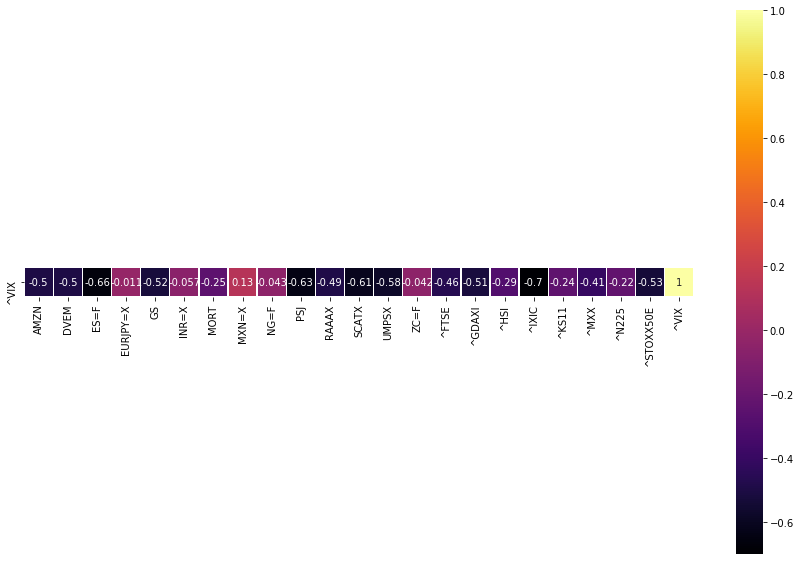

In [156]:
# ZOOMING IN TO SEE IF VIX STILL OFFERS NICE HEDGE 
colormap = plt.cm.inferno
plt.figure(figsize=(15,10))
corr = combo_pca.corr()
sns.heatmap(corr[corr.index == '^VIX'], linewidths=0.3, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);
plt.show()

# Performing PCA

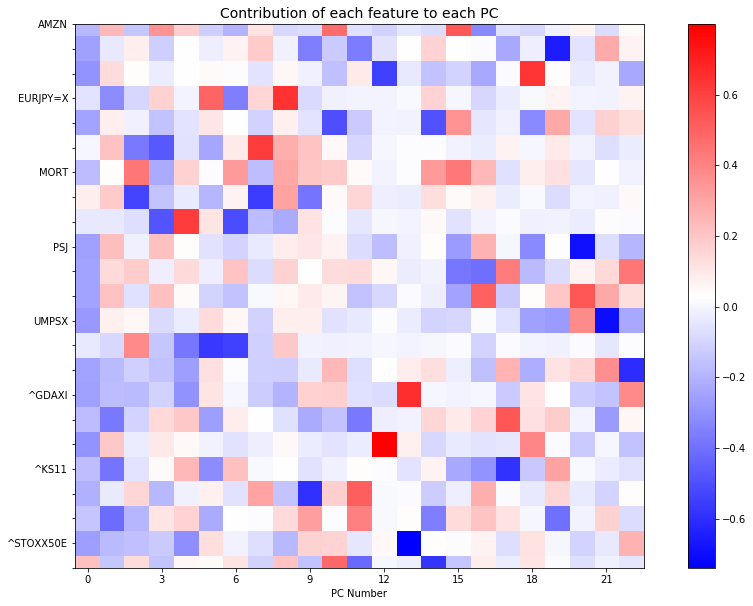

In [157]:
# Perfomring PCA involves calculating the eigenvectors and eigenvalues of the covariance matrix.
# The eigenvectors (principal components) determine the directions of the new feature space,
#and the eigenvalues determine their magnitude, (i.e. the eigenvalues explain the variance of 
# the data along the new feature axes.)

# perform PCA
eig_vals, eig_vecs = np.linalg.eig(c)  
 
ax = plt.figure(figsize=(16,10)).gca()
plt.imshow(eig_vecs, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
#choose only the third label each time as there is not enough space and we only need an overview
plt.yticks(np.arange(len(tickers)), [x if i%3==0 else " " for i, x in enumerate(tickers)])
plt.xlabel("PC Number")
plt.title("Contribution of each feature to each PC", fontsize=14)
# force x-tickers to be displayed as integers
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [158]:
#There are 23 components all together. We can see that the early components (0-40) describe variation across all
#the stocks (red spots in top left corner). It also appears that the variation represented by the later components
#is more distributed.

# The total variability in the system is now represented by the 90 components,
# (as opposed to the 1520 dimensions in the original dataset). 
# The eigenvalues can be used to describe how much variance is explained by each component, 
#(i.e. how the varaiance is distributed across our PC's).

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,45)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,45)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained variance by first %s principal components' % 45)

fig = Figure(data=data, layout=layout)
iplot(fig)

/home/ash/miniconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




In [160]:
var_exp

[43.478918153418554,
 10.375294149721977,
 5.471409065037608,
 5.103448744656871,
 4.332394303096038,
 4.146908446547474,
 3.9123533520329024,
 3.4666558281693036,
 3.2824509923858254,
 2.700637427382422,
 2.1598287931917595,
 1.9746783842564282,
 1.7569109581931905,
 1.507521498780264,
 1.3680893285648146,
 1.2355193835286968,
 0.9587946428332674,
 0.7833841888302104,
 0.7049867285538325,
 0.6235526907572876,
 0.4293804727758959,
 0.12280261154687445,
 0.10407985573851468]

In [188]:
cum_var_exp

array([ 43.47891815,  53.8542123 ,  59.32562137,  64.42907011,
        68.76146442,  72.90837286,  76.82072621,  80.28738204,
        83.56983304,  86.27047046,  88.43029926,  90.40497764,
        92.1618886 ,  93.6694101 ,  95.03749943,  96.27301881,
        97.23181345,  98.01519764,  98.72018437,  99.34373706,
        99.77311753,  99.89592014, 100.        ])

In [186]:
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-1.84791773e-01  2.45194037e-01 -1.38955587e-01  3.50391976e-01
   1.75919450e-01 -1.19630523e-01 -1.92370965e-01  1.17650863e-01
  -8.63960932e-02 -7.54119883e-02  4.69693213e-01 -6.43100497e-02
  -1.07724349e-01 -4.30883990e-02 -7.73931950e-02  5.29506131e-01
  -3.27143968e-01 -5.53125880e-02 -8.97455351e-02 -1.46471322e-02
   6.33359840e-02 -7.24645626e-02  4.69137656e-02]
 [-2.56755664e-01 -3.63213756e-02  7.92574190e-02 -1.17572828e-01
   2.63623349e-02 -1.82248471e-02  7.19184767e-02  1.88064842e-01
  -1.43364344e-02 -3.54061258e-01 -1.28823712e-01 -3.61705109e-01
  -5.82354407e-02  2.56970730e-02  1.57776387e-01  3.24004604e-02
   1.75633150e-02 -2.28794814e-01 -2.25028562e-02 -6.52429276e-01
  -5.13949307e-02  2.86042357e-01  6.93609182e-02]
 [-2.89795953e-01  1.36718103e-01  3.72517824e-02 -2.95675613e-02
   3.47468133e-02  4.49335914e-02  2.37029552e-02 -4.96208656e-02
   5.83699647e-02 -1.35134307e-02 -1.61779055e-01  9.50391429e-02
  -5.44595892e-01 -4.02003

In [164]:
#As we can see, most of the variance is concentrated in the top 1-3 components. These components capture 
#"market wide" effects that impact all members of the dataset.

# Now we plot loadings which load = eigenvec*sqrt(eigenval)

#we will analyse the last few components (third and 4th from the end)
k1 = -1
k2 = -2
k3 = -3
xl = []
yl = []

#set up the labels so that central points are blank
tickers = list(mix_asset_class_rets.columns)

#insert some spacers as we want pairs of labels
for index, item in enumerate(tickers):
    if index % 2 == 0:
        tickers.insert(index,'')


#build up data points for loadings plot
for i in range(eig_vecs.shape[0]):
    x_val = [0,eig_vecs[i,k1]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))]
    y_val = [0,eig_vecs[i,k2]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))]
    xl.append(x_val)
    yl.append(y_val)

#convert list of lists to list     
flattenedx = [val for sublist in xl for val in sublist]
flattenedy = [val for sublist in yl for val in sublist]

traceall = go.Scatter(
    x = flattenedx,
    y = flattenedy,
    mode = 'lines+markers',name = 'all',
    text = tickers,
)

trace1 = go.Scatter(
    x = flattenedx[0:22],
    y = flattenedy[0:22],
    mode = 'lines+markers',name = 'Stocks',
    text = tickers[0:22]
)

trace2 = go.Scatter(
    x = flattenedx[22:((20+45)*2)],
    y = flattenedy[22:((20+45)*2)],
    mode = 'lines+markers',name = 'Sectors',
    text = tickers[22:((20+45)*2)]
)

trace3 = go.Scatter(
    x = flattenedx[((20+45)*2):],
    y = flattenedy[((20+45)*2):],
    mode = 'lines+markers',name = 'Regions',
    text = tickers[((20+45)*2):]
)

layout=Layout(
        yaxis=YAxis(title='PC %s' % (90+k2)),
        xaxis=XAxis(title='PC %s' % (90+k1)),
        title='PCA loadings plot')

data = [trace1,trace2,trace3]
#data = [traceall]
fig = Figure(data=data,layout=layout)
iplot(fig)


# Analysis of loadings to determine correlations 

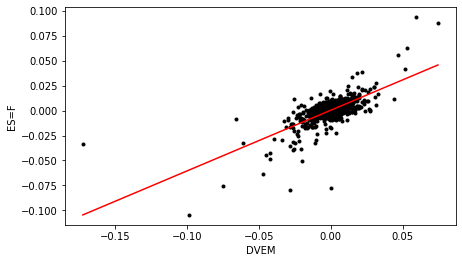

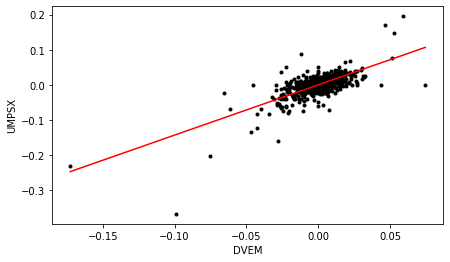

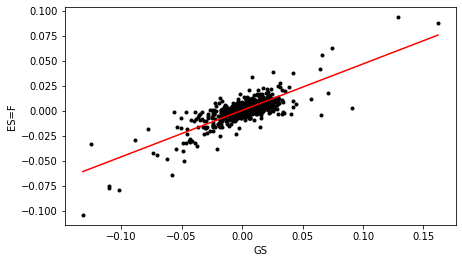

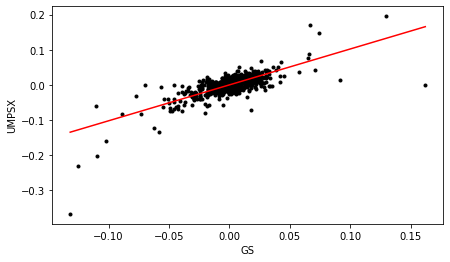

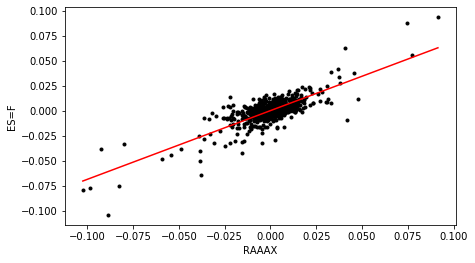

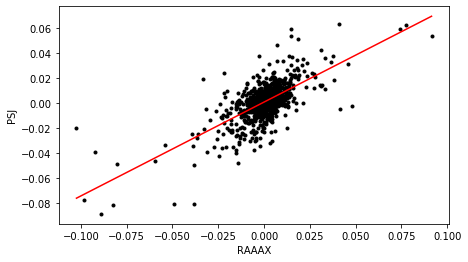

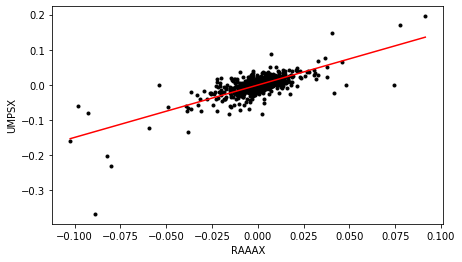

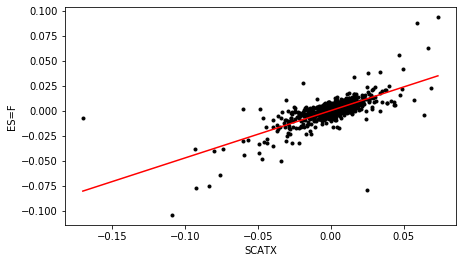

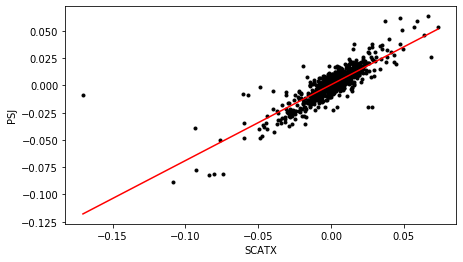

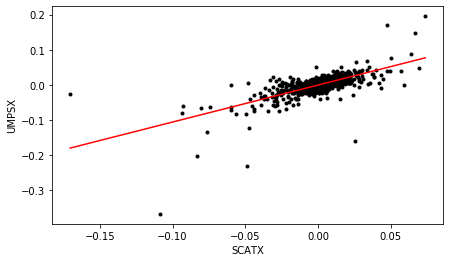

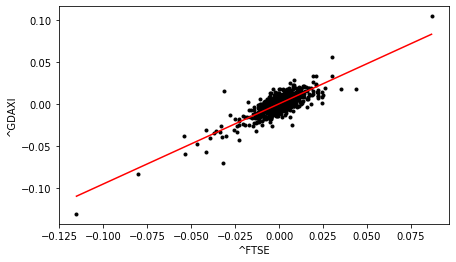

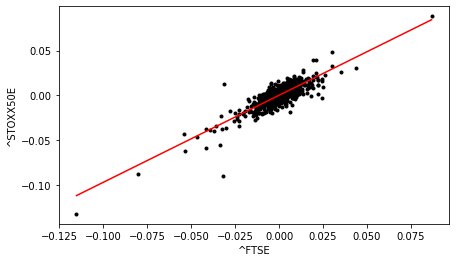

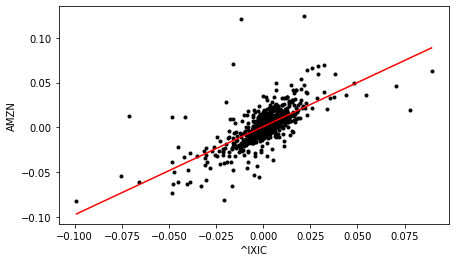

In [180]:
dist=[]
#list to contain tuples (ith example, quandrant location 1,2,3,4)
quad = []

#calculate distances of each point in case we want to filter by only significant results
for i in range(eig_vecs.shape[0]):
    x = eig_vecs[i,k1]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))
    y = eig_vecs[i,k2]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
    
    
    
    #calculate the location of each indicies wrt the quadrant of the loading plot
    if((x > 0) and (y > 0)):
        quad.append((i, 1))
    elif((x < 0) and (y > 0)):
        quad.append((i, 2))
    elif((x < 0) and (y < 0)):
        quad.append((i, 3))
    elif((x > 0) and (y < 0)):
        quad.append((i, 4))
        
        
    #reset the tickers to the original format
tickers = list(mix_asset_class_rets.columns)

#collect the entities for ranking later
corrells = pd.DataFrame(columns=["Stock/index_A","Stock/index_B","R^2"])

#select the stocks only
stocks = tickers[:15]

#calculate quadrant membership and determine opposing pairs
for i in range(len(quad)):
    # Q1 vs Q3
    if(quad[i][1] == 1):
        for j in range(len(quad)):
            #we are only interested in correlations that involve at least 1 stock
            if(quad[j][1] == 3 and ((tickers[quad[i][0]] in stocks) or (tickers[quad[j][0]] in stocks)) ):
                
 
                ts1 = mix_asset_class_rets[tickers[quad[i][0]]]  # time-series for cross plots
                ts2 = mix_asset_class_rets[tickers[quad[j][0]]]
 
                # correlation metrics 
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
                
                #print(r2, pvalue)
                
                #save metrics
                corrells = corrells.append({"Stock/index_A":tickers[quad[i][0]],"Stock/index_B":tickers[quad[j][0]],"R^2":r2},ignore_index=True)
                
                # if the correlation is significant then plot it up
                if (r2>0.6):
                    plt.figure(figsize=(7,4))
                    plt.plot(ts1, ts2, '.k')
                    #linear regression line
                    xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                    yline = slope*xline + intercept
                    plt.plot(xline, yline,'-', color='r') 
                    plt.xlabel(tickers[quad[i][0]])
                    plt.ylabel(tickers[quad[j][0]])
                    plt.show()
                    
    # Q2 vs Q4
    if(quad[i][1] == 2):
        for j in range(len(quad)):
            if(quad[j][1] == 4 and ((tickers[quad[i][0]] in stocks) or (tickers[quad[j][0]] in stocks)) ):
                
                #print(tickers[quad[i][0]], tickers[quad[j][0]])
                ts1 = mix_asset_class_rets[tickers[quad[i][0]]]
                ts2 = mix_asset_class_rets[tickers[quad[j][0]]]
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
               
                #print(r2, pvalue)
                
                corrells = corrells.append({"Stock/index_A":tickers[quad[i][0]],"Stock/index_B":tickers[quad[j][0]],"R^2":r2},ignore_index=True)
                
                if(r2>0.6):
                    plt.figure(figsize=(7,4))
                    plt.plot(ts1, ts2, '.k')
                    xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                    yline = slope*xline + intercept
                    plt.plot(xline, yline,'-', color='r')
                    plt.xlabel(tickers[quad[i][0]])
                    plt.ylabel(tickers[quad[j][0]])
                    plt.show()

In [183]:
corrells = corrells.sort_values(by="R^2",ascending=False)
corrells = corrells.reset_index(drop=True)
corrells.head(50)

,Stock/index_A,Stock/index_B,R^2
0,^FTSE,^STOXX50E,0.853379
1,SCATX,PSJ,0.842993
2,^FTSE,^GDAXI,0.826553
3,RAAAX,ES=F,0.798173
4,GS,ES=F,0.795957
5,GS,UMPSX,0.741867
6,RAAAX,UMPSX,0.732930
7,SCATX,ES=F,0.725337
8,DVEM,ES=F,0.709255
9,DVEM,UMPSX,0.707548


In [ ]:
#The top correlations listed in the above table are broadly consistent with the manual examples supplied and 
#the results of the correlation heatmap produced in section 5. 